# LSCTS
+ large scale Chinese short text summarization dataset)
+ 中文社交媒体文本，LCSTS数据集的特点是文本篇幅较短，并且存在噪声
+ 训练集大小	2400000
+ 验证集大小	10000
+ 测试集大小	1000

In [1]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer 

model = None
tokenizer = None
device = "cuda" if torch.cuda.is_available() else "cpu" 

with torch.no_grad():
    # model_ckpt = "google/pegasus-cnn_dailymail" 
    model_ckpt = '../../../resources/embedding/google_pegasus-cnn-dm'
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt) 
    model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device) 

/home/users/sunhongchao/miniconda3/envs/bot-mvp/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import datasets
import pandas as pd
from datasets import Dataset, load_dataset

# from transformers import BertTokenizer
# TokenModel = "../../../resources/embedding/t5-large"
# tokenizer = BertTokenizer.from_pretrained(TokenModel)

max_input_length = 128
max_target_length = 32
 
lcsts_part_1=pd.read_table('../../../resources/dataset/lscts/DATA/PART_II.txt', header=None,
                           warn_bad_lines=True, error_bad_lines=False, sep='<[/d|/s|do|su|sh][^a].*>', encoding='utf-8') # PART I  too big, use PART II instead
lcsts_part_1=lcsts_part_1[0].dropna()
lcsts_part_1=lcsts_part_1.reset_index(drop=True)
lcsts_part_1=pd.concat([lcsts_part_1[1::2].reset_index(drop=True), lcsts_part_1[::2].reset_index(drop=True)], axis=1)
lcsts_part_1.columns=['document', 'summary']
 
lcsts_part_2=pd.read_table('../../../resources/dataset/lscts/DATA/PART_II.txt', header=None,
                           warn_bad_lines=True, error_bad_lines=False, sep='<[/d|/s|do|su|sh][^a].*>', encoding='utf-8')
lcsts_part_2=lcsts_part_2[0].dropna()
lcsts_part_2=lcsts_part_2.reset_index(drop=True)
lcsts_part_2=pd.concat([lcsts_part_2[1::2].reset_index(drop=True), lcsts_part_2[::2].reset_index(drop=True)], axis=1)
lcsts_part_2.columns=['document', 'summary']
 
dataset_train = Dataset.from_dict(lcsts_part_1)
dataset_valid = Dataset.from_dict(lcsts_part_2)

d_len = [len(tokenizer.encode(s['document'])) for s in dataset_train] 
s_len = [len(tokenizer.encode(s['summary'])) for s in dataset_train] 

/home/users/sunhongchao/miniconda3/envs/bot-mvp/lib/python3.6/site-packages/pandas/io/parsers.py:767: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return read_csv(**locals())


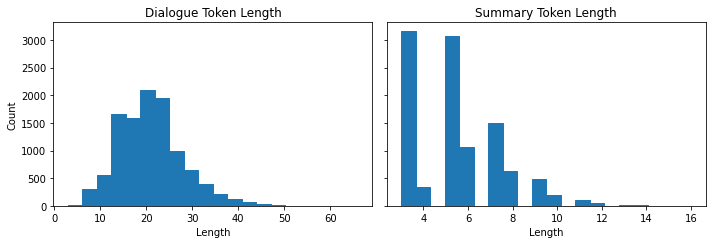

In [3]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0") 
axes[0].set_title("Dialogue Token Length") 
axes[0].set_xlabel("Length") 
axes[0].set_ylabel("Count") 
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0") 
axes[1].set_title("Summary Token Length") 
axes[1].set_xlabel("Length") 
plt.tight_layout() 

In [4]:
# def preprocess_function(examples):
#     inputs = [str(doc) for doc in examples["document"]]
#     model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)
#     inputs = [str(doc) for doc in examples["summary"]]
#     # Setup the tokenizer for targets
#     with tokenizer.as_target_tokenizer():
#         labels = tokenizer(inputs, max_length=max_target_length, truncation=True)
 
#     model_inputs["labels"] = labels["input_ids"]
#     return model_inputs

# tokenized_datasets_t = dataset_train.map(preprocess_function, batched=True)
# tokenized_datasets_v = dataset_valid.map(preprocess_function, batched=True)
 
# tokenized_datasets = datasets.DatasetDict({"train":tokenized_datasets_t,"validation": tokenized_datasets_v})
# print(tokenized_datasets)
# print(tokenized_datasets['train'][0])

In [5]:
# https://xiaosheng.run/2022/03/29/transformers-note-8.html

In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import AdamW, get_scheduler
from tqdm.auto import tqdm
from rouge import Rouge
import random
import numpy as np
import os

max_dataset_size = 200000
max_input_length = 128
max_target_length = 32
train_batch_size = 8
test_batch_size = 8
learning_rate = 2e-5
epoch_num = 3
beam_size = 4
no_repeat_ngram_size = 2

seed = 5
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

class LCSTS(Dataset):
    def __init__(self, data_file):
        self.data = self.load_data(data_file)
    
    def load_data(self, data_file):
        Data = {}
        with open(data_file, 'rt', encoding='utf-8') as f:
            for idx, line in enumerate(f):
                if idx >= max_dataset_size:
                    break
                items = line.strip().split('!=!')
                assert len(items) == 2
                Data[idx] = {
                    'title': items[0],
                    'content': items[1]
                }
        return Data
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# train_data = LCSTS('lcsts_tsv/data1.tsv')
# valid_data = LCSTS('lcsts_tsv/data2.tsv')
# test_data = LCSTS('lcsts_tsv/data3.tsv')

# dataset_train = Dataset.from_dict(lcsts_part_1)
# dataset_valid = Dataset.from_dict(lcsts_part_2)

train_data = dataset_train
valid_data = dataset_valid
test_data = dataset_valid

model_checkpoint = "csebuetnlp/mT5_multilingual_XLSum"
model_checkpoint = "../../../resources/embedding/google_pegasus-cnn-dm"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
model = model.to(device)

def collote_fn(batch_samples):
    batch_inputs, batch_targets = [], []
    for sample in batch_samples:
        # print(sample)
        batch_inputs.append(sample['document'])
        batch_targets.append(sample['summary'])
    batch_data = tokenizer(
        batch_inputs, 
        padding=True, 
        max_length=max_input_length,
        truncation=True, 
        return_tensors="pt"
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            batch_targets, 
            padding=True, 
            max_length=max_target_length,
            truncation=True, 
            return_tensors="pt"
        )["input_ids"]
        batch_data['decoder_input_ids'] = model.prepare_decoder_input_ids_from_labels(labels)
        end_token_index = torch.where(labels == tokenizer.eos_token_id)[1]
        for idx, end_idx in enumerate(end_token_index):
            labels[idx][end_idx+1:] = -100
        batch_data['labels'] = labels
    return batch_data

train_dataloader = DataLoader(dataset_train, batch_size=train_batch_size, shuffle=True, collate_fn=collote_fn)
valid_dataloader = DataLoader(dataset_valid, batch_size=test_batch_size, shuffle=False, collate_fn=collote_fn)

def train_loop(dataloader, model, optimizer, lr_scheduler, epoch, total_loss):
    progress_bar = tqdm(range(len(dataloader)))
    progress_bar.set_description(f'loss: {0:>7f}')
    finish_batch_num = (epoch-1) * len(dataloader)
    
    model.train()
    for batch, batch_data in enumerate(dataloader, start=1):
        batch_data = batch_data.to(device)
        outputs = model(**batch_data)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        progress_bar.set_description(f'loss: {total_loss/(finish_batch_num + batch):>7f}')
        progress_bar.update(1)
    return total_loss

rouge = Rouge()

def test_loop(dataloader, model, mode='Test'):
    assert mode in ['Valid', 'Test']
    preds, labels = [], []
    
    model.eval()
    for batch_data in tqdm(dataloader):
        batch_data = batch_data.to(device)
        with torch.no_grad():
            generated_tokens = model.generate(
                batch_data["input_ids"],
                attention_mask=batch_data["attention_mask"],
                max_length=max_target_length,
                num_beams=beam_size,
                no_repeat_ngram_size=no_repeat_ngram_size,
            ).cpu().numpy()
        if isinstance(generated_tokens, tuple):
            generated_tokens = generated_tokens[0]
        label_tokens = batch_data["labels"].cpu().numpy()

        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        label_tokens = np.where(label_tokens != -100, label_tokens, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(label_tokens, skip_special_tokens=True)

        preds += [' '.join(pred.strip()) for pred in decoded_preds]
        labels += [' '.join(label.strip()) for label in decoded_labels]
    if not preds:
        continue
    if not labels:
        continue
    scores = rouge.get_scores(hyps=preds, refs=labels, avg=True)
    result = {key: value['f'] * 100 for key, value in scores.items()}
    result['avg'] = np.mean(list(result.values()))
    print(f"{mode} Rouge1: {result['rouge-1']:>0.2f} Rouge2: {result['rouge-2']:>0.2f} RougeL: {result['rouge-l']:>0.2f}\n")
    return result

optimizer = AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=epoch_num*len(train_dataloader),
)

total_loss = 0.
best_avg_rouge = 0.
for t in range(epoch_num):
    print(f"Epoch {t+1}/{epoch_num}\n-------------------------------")
    total_loss = train_loop(train_dataloader, model, optimizer, lr_scheduler, t+1, total_loss)
    valid_rouge = test_loop(valid_dataloader, model, mode='Valid')
    rouge_avg = valid_rouge['avg']
    if rouge_avg > best_avg_rouge:
        best_avg_rouge = rouge_avg
        print('saving new weights...\n')
        torch.save(model.state_dict(), f'epoch_{t+1}_valid_rouge_{rouge_avg:0.4f}_model_weights.bin')
print("Done!")

Using cuda device


/home/users/sunhongchao/miniconda3/envs/bot-mvp/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch 1/3
-------------------------------


100%|██████████| 1334/1334 [17:30<00:00,  1.27it/s]


ValueError: Collections must contain at least 1 sentence.